In [483]:
import os, random
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [484]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [485]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [486]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [487]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [488]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [489]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.1
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Train data shape: (263, 1435)
Test data shape: (2445, 1435)
Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [550]:
def generate_data(training_size):
    # train: 140, val: 15%, test: 1000
    train_data, val_data, test_data = [], [], []

    for _, group_data in papers.groupby("subject"):
        # Select around 50% of the dataset for training.
        train_num = int(np.round(len(group_data.index) / len(papers.index) * training_size))
        val_num = max(int(np.round(len(group_data.index) / len(papers.index) * int(training_size/0.85*0.15))), 1)
        test_num = int(np.round(len(group_data.index) / len(papers.index) * 1000))
        total = train_num + val_num + test_num
        random_selection = random.sample(range(len(group_data.index)), total) 
        random_selection_train = [i in random_selection[:train_num] for i in range(len(group_data.index))]
        random_selection_val = [i in random_selection[train_num:train_num + val_num] for i in range(len(group_data.index))]
        random_selection_test = [i in random_selection[train_num + val_num:] for i in range(len(group_data.index))]
        train_data.append(group_data[random_selection_train])
        val_data.append(group_data[random_selection_val])
        test_data.append(group_data[random_selection_test])

    train_data = pd.concat(train_data).sample(frac=1)
    val_data = pd.concat(val_data).sample(frac=1)
    test_data = pd.concat(test_data).sample(frac=1)

    print("Train data shape:", train_data.shape)
    print("Val data shape:", val_data.shape)
    print("Test data shape:", test_data.shape)

    feature_names = set(papers.columns) - {"paper_id", "subject"}
    num_features = len(feature_names)
    num_classes = len(class_idx)

    # Create train and test features as a numpy array.
    x_train = train_data.paper_id.to_numpy()
    x_val = val_data.paper_id.to_numpy()
    x_test = test_data.paper_id.to_numpy()
    # Create train and test targets as a numpy array.
    y_train = train_data["subject"]
    y_val = val_data["subject"]
    y_test = test_data["subject"]
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = generate_data(30)

Train data shape: (30, 1435)
Val data shape: (8, 1435)
Test data shape: (999, 1435)


In [491]:
hidden_units = [32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 50
batch_size = x_train.shape[0]

In [492]:
def run_experiment(model, x_train, y_train, x_val, y_val, batch_size):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        #metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
        loss=keras.losses.CategoricalCrossentropy(from_logits=True,label_smoothing=0.2),
        metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=30, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        #validation_split=0.15,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping],
    )

    return history

In [493]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [494]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        #self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = layers.Dense(hidden_units[0], activation=tf.nn.relu)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages. self-loop
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        #neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_repesentations)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [495]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="add",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            [100],
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="convoluted_layer",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            [200],
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="convoluted_layer",
        )
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits", activation=tf.nn.softmax)

    def call(self, input_node_indices):
        # Apply the first graph conv layer.
        x = self.conv1((self.node_features, self.edges, self.edge_weights))
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.squeeze(tf.gather(x2, input_node_indices))
        # Compute logits
        return self.compute_logits(node_embeddings)

In [597]:
gcn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gcn_model",
)

print("GCN output shape:", gcn_model([1, 10, 100]))

gcn_model.summary()

GCN output shape: tf.Tensor(
[[0.1549314  0.13846469 0.14031968 0.1298037  0.17438373 0.12362158
  0.13847528]
 [0.16079246 0.12309013 0.13143064 0.12971275 0.17583278 0.11746866
  0.16167253]
 [0.14051609 0.14880395 0.14211638 0.11813128 0.16393888 0.12605405
  0.16043936]], shape=(3, 7), dtype=float32)
Model: "gcn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convoluted_layer (GraphConvL multiple                  143400    
_________________________________________________________________
convoluted_layer (GraphConvL multiple                  20200     
_________________________________________________________________
logits (Dense)               multiple                  1407      
Total params: 165,007
Trainable params: 165,007
Non-trainable params: 0
_________________________________________________________________


In [598]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_data(20)
if (x_train.shape[0] % 5 == 1 and x_train.shape[0] != 36):
    history = run_experiment(gcn_model, x_train[:-1], keras.utils.to_categorical(y_train[:-1], 7), x_val, keras.utils.to_categorical(y_val, 7), x_train[:-1].shape[0] // 5)
elif (x_train.shape[0] == 39 or x_train.shape[0] == 36):
    history = run_experiment(gcn_model, x_train[:-1], keras.utils.to_categorical(y_train[:-1], 7), x_val[:-1], keras.utils.to_categorical(y_val[:-1], 7), x_train[:-1].shape[0] // 5)
else:
    history = run_experiment(gcn_model, x_train, keras.utils.to_categorical(y_train, 7), x_val, keras.utils.to_categorical(y_val, 7), x_train.shape[0] // 5)

Train data shape: (20, 1435)
Val data shape: (7, 1435)
Test data shape: (999, 1435)
Epoch 1/50
5/5 [==============================] - 3s 346ms/step - loss: 1.9480 - acc: 0.0438 - val_loss: 1.9363 - val_acc: 0.1429
Epoch 2/50
5/5 [==============================] - 1s 183ms/step - loss: 1.8999 - acc: 0.3556 - val_loss: 1.9272 - val_acc: 0.1429
Epoch 3/50
5/5 [==============================] - 1s 198ms/step - loss: 1.8193 - acc: 0.7375 - val_loss: 1.8890 - val_acc: 0.4286
Epoch 4/50
5/5 [==============================] - 1s 189ms/step - loss: 1.7636 - acc: 0.8701 - val_loss: 1.8630 - val_acc: 0.7143
Epoch 5/50
5/5 [==============================] - 1s 200ms/step - loss: 1.7153 - acc: 0.8972 - val_loss: 1.8292 - val_acc: 0.7143
Epoch 6/50
5/5 [==============================] - 1s 223ms/step - loss: 1.6545 - acc: 0.8965 - val_loss: 1.7874 - val_acc: 0.8571
Epoch 7/50
5/5 [==============================] - 1s 295ms/step - loss: 1.5626 - acc: 1.0000 - val_loss: 1.7521 - val_acc: 0.8571
Epoch 

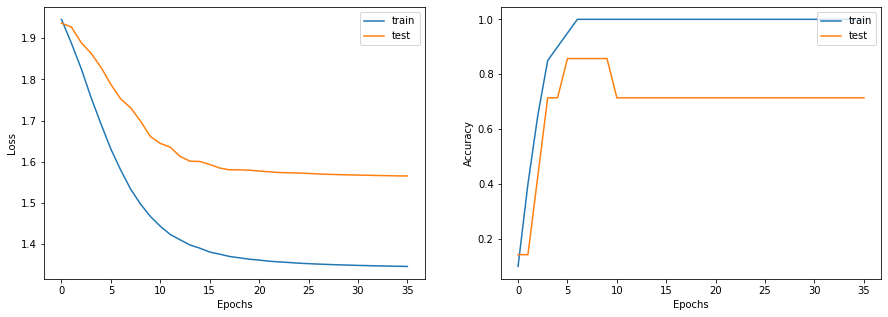

In [599]:
display_learning_curves(history)

In [600]:
_, test_accuracy = gcn_model.evaluate(x=x_test, y=keras.utils.to_categorical(y_test, 7), verbose=0)
#_, test_accuracy = gcn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 57.56%


In [601]:
print(train_data.subject.value_counts())
print(papers.subject.value_counts())

2    89
3    58
1    34
6    24
0    24
4    20
5    14
Name: subject, dtype: int64
2    818
3    426
1    418
6    351
0    298
4    217
5    180
Name: subject, dtype: int64


In [602]:
histories = []
test_accs = []
for size in range(140, 15, -5):
    x_train, x_val, x_test, y_train, y_val, y_test = generate_data(size)
    gcn_model = GNNNodeClassifier(
        graph_info=graph_info,
        num_classes=num_classes,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        name="gcn_model",
    )
    print("GCN output shape:", gcn_model([1, 10, 100]))
    gcn_model.summary()
    if (x_train.shape[0] % 5 == 1 and x_train.shape[0] != 36):
        history = run_experiment(gcn_model, x_train[:-1], keras.utils.to_categorical(y_train[:-1], 7), x_val, keras.utils.to_categorical(y_val, 7), x_train[:-1].shape[0] // 5)
    elif (x_train.shape[0] == 39 or x_train.shape[0] == 36):
        history = run_experiment(gcn_model, x_train[:-1], keras.utils.to_categorical(y_train[:-1], 7), x_val[:-1], keras.utils.to_categorical(y_val[:-1], 7), x_train[:-1].shape[0] // 5)
    else:
        history = run_experiment(gcn_model, x_train, keras.utils.to_categorical(y_train, 7), x_val, keras.utils.to_categorical(y_val, 7), x_train.shape[0] // 5)
    _, test_accuracy = gcn_model.evaluate(x=x_test, y=keras.utils.to_categorical(y_test, 7), verbose=0)
    print(test_accuracy)
    histories.append(history)
    test_accs.append(round(test_accuracy * 100, 2))

Train data shape: (139, 1435)
Val data shape: (25, 1435)
Test data shape: (999, 1435)
GCN output shape: tf.Tensor(
[[0.13868618 0.15285487 0.12238733 0.13490383 0.14540015 0.17038856
  0.13537909]
 [0.1441611  0.13920467 0.12589444 0.13533947 0.13839918 0.18166173
  0.1353394 ]
 [0.1258793  0.14078788 0.1300443  0.14738993 0.13335623 0.17961736
  0.14292501]], shape=(3, 7), dtype=float32)
Model: "gcn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convoluted_layer (GraphConvL multiple                  143400    
_________________________________________________________________
convoluted_layer (GraphConvL multiple                  20200     
_________________________________________________________________
logits (Dense)               multiple                  1407      
Total params: 165,007
Trainable params: 165,007
Non-trainable params: 0
_______________________________________________________

5/5 [==============================] - 1s 171ms/step - loss: 1.4371 - acc: 1.0000 - val_loss: 1.6532 - val_acc: 0.6400
Epoch 9/50
5/5 [==============================] - 1s 172ms/step - loss: 1.4069 - acc: 1.0000 - val_loss: 1.6421 - val_acc: 0.6800
Epoch 10/50
5/5 [==============================] - 1s 174ms/step - loss: 1.3879 - acc: 1.0000 - val_loss: 1.6342 - val_acc: 0.6800
Epoch 11/50
5/5 [==============================] - 1s 166ms/step - loss: 1.3774 - acc: 1.0000 - val_loss: 1.6286 - val_acc: 0.6800
Epoch 12/50
5/5 [==============================] - 1s 172ms/step - loss: 1.3655 - acc: 1.0000 - val_loss: 1.6245 - val_acc: 0.6800
Epoch 13/50
5/5 [==============================] - 1s 173ms/step - loss: 1.3612 - acc: 1.0000 - val_loss: 1.6214 - val_acc: 0.6800
Epoch 14/50
5/5 [==============================] - 1s 177ms/step - loss: 1.3557 - acc: 1.0000 - val_loss: 1.6190 - val_acc: 0.6800
Epoch 15/50
5/5 [==============================] - 1s 165ms/step - loss: 1.3530 - acc: 1.0000 - 

Epoch 26/50
6/6 [==============================] - 1s 139ms/step - loss: 1.3430 - acc: 1.0000 - val_loss: 1.5785 - val_acc: 0.6667
Epoch 27/50
6/6 [==============================] - 1s 125ms/step - loss: 1.3424 - acc: 1.0000 - val_loss: 1.5776 - val_acc: 0.6667
Epoch 28/50
6/6 [==============================] - 1s 194ms/step - loss: 1.3422 - acc: 1.0000 - val_loss: 1.5771 - val_acc: 0.6667
Epoch 29/50
6/6 [==============================] - 1s 154ms/step - loss: 1.3416 - acc: 1.0000 - val_loss: 1.5766 - val_acc: 0.6667
Epoch 30/50
6/6 [==============================] - 1s 158ms/step - loss: 1.3416 - acc: 1.0000 - val_loss: 1.5762 - val_acc: 0.6667
Epoch 31/50
6/6 [==============================] - 1s 165ms/step - loss: 1.3413 - acc: 1.0000 - val_loss: 1.5758 - val_acc: 0.6667
Epoch 32/50
6/6 [==============================] - 1s 153ms/step - loss: 1.3413 - acc: 1.0000 - val_loss: 1.5756 - val_acc: 0.6667
Epoch 33/50
6/6 [==============================] - 1s 161ms/step - loss: 1.3408 - a

Epoch 4/50
5/5 [==============================] - 1s 163ms/step - loss: 1.7155 - acc: 0.9234 - val_loss: 1.7590 - val_acc: 0.6500
Epoch 5/50
5/5 [==============================] - 1s 160ms/step - loss: 1.6316 - acc: 0.9829 - val_loss: 1.7267 - val_acc: 0.6000
Epoch 6/50
5/5 [==============================] - 1s 166ms/step - loss: 1.5402 - acc: 1.0000 - val_loss: 1.7009 - val_acc: 0.6000
Epoch 7/50
5/5 [==============================] - 1s 164ms/step - loss: 1.5155 - acc: 1.0000 - val_loss: 1.6828 - val_acc: 0.6000
Epoch 8/50
5/5 [==============================] - 1s 171ms/step - loss: 1.4614 - acc: 1.0000 - val_loss: 1.6688 - val_acc: 0.6000
Epoch 9/50
5/5 [==============================] - 1s 162ms/step - loss: 1.4205 - acc: 1.0000 - val_loss: 1.6578 - val_acc: 0.6000
Epoch 10/50
5/5 [==============================] - 1s 117ms/step - loss: 1.3991 - acc: 1.0000 - val_loss: 1.6508 - val_acc: 0.6000
Epoch 11/50
5/5 [==============================] - 1s 136ms/step - loss: 1.3817 - acc: 1.

Epoch 25/50
5/5 [==============================] - 1s 166ms/step - loss: 1.3442 - acc: 1.0000 - val_loss: 1.5809 - val_acc: 0.6500
Epoch 26/50
5/5 [==============================] - 1s 164ms/step - loss: 1.3441 - acc: 1.0000 - val_loss: 1.5807 - val_acc: 0.6500
Epoch 27/50
5/5 [==============================] - 1s 166ms/step - loss: 1.3434 - acc: 1.0000 - val_loss: 1.5808 - val_acc: 0.6500
Epoch 28/50
5/5 [==============================] - 1s 169ms/step - loss: 1.3429 - acc: 1.0000 - val_loss: 1.5810 - val_acc: 0.6500
Epoch 29/50
5/5 [==============================] - 1s 172ms/step - loss: 1.3426 - acc: 1.0000 - val_loss: 1.5808 - val_acc: 0.6500
Epoch 30/50
5/5 [==============================] - 1s 166ms/step - loss: 1.3421 - acc: 1.0000 - val_loss: 1.5806 - val_acc: 0.6500
Epoch 31/50
5/5 [==============================] - 1s 169ms/step - loss: 1.3419 - acc: 1.0000 - val_loss: 1.5804 - val_acc: 0.6500
Epoch 32/50
5/5 [==============================] - 1s 168ms/step - loss: 1.3416 - a

Epoch 32/50
6/6 [==============================] - 1s 155ms/step - loss: 1.3412 - acc: 1.0000 - val_loss: 1.4637 - val_acc: 0.8421
Epoch 33/50
6/6 [==============================] - 1s 159ms/step - loss: 1.3409 - acc: 1.0000 - val_loss: 1.4636 - val_acc: 0.8421
0.6856856942176819
Train data shape: (106, 1435)
Val data shape: (17, 1435)
Test data shape: (999, 1435)
GCN output shape: tf.Tensor(
[[0.12866925 0.15690047 0.12902208 0.13564013 0.12778044 0.16877821
  0.15320945]
 [0.12545101 0.14518072 0.1495217  0.126611   0.13142909 0.16752838
  0.15427811]
 [0.12383888 0.13891883 0.14858857 0.12232835 0.13496539 0.17207296
  0.15928704]], shape=(3, 7), dtype=float32)
Model: "gcn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convoluted_layer (GraphConvL multiple                  143400    
_________________________________________________________________
convoluted_layer (GraphConvL multiple       

Epoch 10/50
5/5 [==============================] - 1s 161ms/step - loss: 1.4099 - acc: 1.0000 - val_loss: 1.6547 - val_acc: 0.6471
Epoch 11/50
5/5 [==============================] - 1s 163ms/step - loss: 1.3927 - acc: 1.0000 - val_loss: 1.6475 - val_acc: 0.6471
Epoch 12/50
5/5 [==============================] - 1s 164ms/step - loss: 1.3792 - acc: 1.0000 - val_loss: 1.6422 - val_acc: 0.6471
Epoch 13/50
5/5 [==============================] - 1s 161ms/step - loss: 1.3697 - acc: 1.0000 - val_loss: 1.6394 - val_acc: 0.6471
Epoch 14/50
5/5 [==============================] - 1s 175ms/step - loss: 1.3635 - acc: 1.0000 - val_loss: 1.6372 - val_acc: 0.6471
Epoch 15/50
5/5 [==============================] - 1s 167ms/step - loss: 1.3577 - acc: 1.0000 - val_loss: 1.6352 - val_acc: 0.6471
Epoch 16/50
5/5 [==============================] - 1s 172ms/step - loss: 1.3541 - acc: 1.0000 - val_loss: 1.6334 - val_acc: 0.6471
Epoch 17/50
5/5 [==============================] - 1s 170ms/step - loss: 1.3524 - a

5/5 [==============================] - 1s 151ms/step - loss: 1.3427 - acc: 1.0000 - val_loss: 1.3931 - val_acc: 0.9375
Epoch 31/50
5/5 [==============================] - 1s 105ms/step - loss: 1.3421 - acc: 1.0000 - val_loss: 1.3929 - val_acc: 0.9375
Epoch 32/50
5/5 [==============================] - 1s 124ms/step - loss: 1.3417 - acc: 1.0000 - val_loss: 1.3927 - val_acc: 0.9375
Epoch 33/50
5/5 [==============================] - 1s 162ms/step - loss: 1.3415 - acc: 1.0000 - val_loss: 1.3925 - val_acc: 0.9375
Epoch 34/50
5/5 [==============================] - 1s 159ms/step - loss: 1.3417 - acc: 1.0000 - val_loss: 1.3925 - val_acc: 0.9375
Epoch 35/50
5/5 [==============================] - 1s 167ms/step - loss: 1.3411 - acc: 1.0000 - val_loss: 1.3924 - val_acc: 0.9375
Epoch 36/50
5/5 [==============================] - 1s 163ms/step - loss: 1.3412 - acc: 1.0000 - val_loss: 1.3922 - val_acc: 0.9375
0.684684693813324
Train data shape: (90, 1435)
Val data shape: (15, 1435)
Test data shape: (999

Epoch 3/50
5/5 [==============================] - 1s 229ms/step - loss: 1.7656 - acc: 0.9065 - val_loss: 1.7736 - val_acc: 0.8000
Epoch 4/50
5/5 [==============================] - 1s 221ms/step - loss: 1.6747 - acc: 0.9719 - val_loss: 1.7210 - val_acc: 0.8667
Epoch 5/50
5/5 [==============================] - 1s 182ms/step - loss: 1.6076 - acc: 0.9513 - val_loss: 1.6791 - val_acc: 0.8667
Epoch 6/50
5/5 [==============================] - 1s 232ms/step - loss: 1.5495 - acc: 0.9855 - val_loss: 1.6388 - val_acc: 0.8000
Epoch 7/50
5/5 [==============================] - 1s 170ms/step - loss: 1.5000 - acc: 0.9855 - val_loss: 1.6102 - val_acc: 0.8000
Epoch 8/50
5/5 [==============================] - 1s 168ms/step - loss: 1.4498 - acc: 0.9961 - val_loss: 1.5807 - val_acc: 0.8000
Epoch 9/50
5/5 [==============================] - 1s 163ms/step - loss: 1.4353 - acc: 0.9757 - val_loss: 1.5629 - val_acc: 0.8000
Epoch 10/50
5/5 [==============================] - 1s 162ms/step - loss: 1.4144 - acc: 0.9

Epoch 23/50
6/6 [==============================] - 1s 180ms/step - loss: 1.3460 - acc: 1.0000 - val_loss: 1.6304 - val_acc: 0.6429
Epoch 24/50
6/6 [==============================] - 1s 152ms/step - loss: 1.3452 - acc: 1.0000 - val_loss: 1.6301 - val_acc: 0.6429
Epoch 25/50
6/6 [==============================] - 1s 161ms/step - loss: 1.3442 - acc: 1.0000 - val_loss: 1.6300 - val_acc: 0.6429
Epoch 26/50
6/6 [==============================] - 1s 195ms/step - loss: 1.3436 - acc: 1.0000 - val_loss: 1.6297 - val_acc: 0.6429
Epoch 27/50
6/6 [==============================] - 1s 202ms/step - loss: 1.3430 - acc: 1.0000 - val_loss: 1.6293 - val_acc: 0.6429
Epoch 28/50
6/6 [==============================] - 1s 177ms/step - loss: 1.3429 - acc: 1.0000 - val_loss: 1.6291 - val_acc: 0.6429
Epoch 29/50
6/6 [==============================] - 1s 207ms/step - loss: 1.3426 - acc: 1.0000 - val_loss: 1.6292 - val_acc: 0.6429
Epoch 30/50
6/6 [==============================] - 1s 193ms/step - loss: 1.3423 - a

Epoch 2/50
5/5 [==============================] - 1s 177ms/step - loss: 1.8571 - acc: 0.3565 - val_loss: 1.8525 - val_acc: 0.6923
Epoch 3/50
5/5 [==============================] - 1s 184ms/step - loss: 1.7771 - acc: 0.7393 - val_loss: 1.8258 - val_acc: 0.5385
Epoch 4/50
5/5 [==============================] - 1s 194ms/step - loss: 1.6845 - acc: 0.8984 - val_loss: 1.7582 - val_acc: 0.6923
Epoch 5/50
5/5 [==============================] - 1s 189ms/step - loss: 1.6412 - acc: 0.8937 - val_loss: 1.7278 - val_acc: 0.6154
Epoch 6/50
5/5 [==============================] - 1s 175ms/step - loss: 1.5450 - acc: 0.9952 - val_loss: 1.6935 - val_acc: 0.6154
Epoch 7/50
5/5 [==============================] - 1s 110ms/step - loss: 1.5097 - acc: 1.0000 - val_loss: 1.6665 - val_acc: 0.6154
Epoch 8/50
5/5 [==============================] - 1s 164ms/step - loss: 1.4729 - acc: 1.0000 - val_loss: 1.6502 - val_acc: 0.6154
Epoch 9/50
5/5 [==============================] - 1s 211ms/step - loss: 1.4385 - acc: 1.00

Epoch 24/50
6/6 [==============================] - 1s 201ms/step - loss: 1.3448 - acc: 1.0000 - val_loss: 1.5388 - val_acc: 0.7273
Epoch 25/50
6/6 [==============================] - 1s 164ms/step - loss: 1.3447 - acc: 1.0000 - val_loss: 1.5386 - val_acc: 0.7273
Epoch 26/50
6/6 [==============================] - 1s 164ms/step - loss: 1.3443 - acc: 1.0000 - val_loss: 1.5387 - val_acc: 0.7273
Epoch 27/50
6/6 [==============================] - 1s 166ms/step - loss: 1.3437 - acc: 1.0000 - val_loss: 1.5391 - val_acc: 0.7273
Epoch 28/50
6/6 [==============================] - 1s 163ms/step - loss: 1.3430 - acc: 1.0000 - val_loss: 1.5393 - val_acc: 0.7273
Epoch 29/50
6/6 [==============================] - 1s 173ms/step - loss: 1.3432 - acc: 1.0000 - val_loss: 1.5397 - val_acc: 0.7273
Epoch 30/50
6/6 [==============================] - 1s 175ms/step - loss: 1.3425 - acc: 1.0000 - val_loss: 1.5393 - val_acc: 0.7273
Epoch 31/50
6/6 [==============================] - 1s 156ms/step - loss: 1.3420 - a

Epoch 1/50
5/5 [==============================] - 4s 390ms/step - loss: 1.9317 - acc: 0.3040 - val_loss: 1.9036 - val_acc: 0.3333
Epoch 2/50
5/5 [==============================] - 1s 167ms/step - loss: 1.8904 - acc: 0.2917 - val_loss: 1.8798 - val_acc: 0.3333
Epoch 3/50
5/5 [==============================] - 1s 184ms/step - loss: 1.8077 - acc: 0.5573 - val_loss: 1.8340 - val_acc: 0.4444
Epoch 4/50
5/5 [==============================] - 1s 198ms/step - loss: 1.7369 - acc: 0.6947 - val_loss: 1.8019 - val_acc: 0.6667
Epoch 5/50
5/5 [==============================] - 1s 254ms/step - loss: 1.6637 - acc: 0.8114 - val_loss: 1.7824 - val_acc: 0.5556
Epoch 6/50
5/5 [==============================] - 1s 219ms/step - loss: 1.5772 - acc: 0.9851 - val_loss: 1.7598 - val_acc: 0.5556
Epoch 7/50
5/5 [==============================] - 1s 210ms/step - loss: 1.5453 - acc: 1.0000 - val_loss: 1.7400 - val_acc: 0.5556
Epoch 8/50
5/5 [==============================] - 1s 182ms/step - loss: 1.5400 - acc: 1.00

Epoch 21/50
5/5 [==============================] - 1s 152ms/step - loss: 1.3487 - acc: 1.0000 - val_loss: 1.5298 - val_acc: 0.6250
Epoch 22/50
5/5 [==============================] - 1s 115ms/step - loss: 1.3490 - acc: 1.0000 - val_loss: 1.5284 - val_acc: 0.6250
Epoch 23/50
5/5 [==============================] - 1s 164ms/step - loss: 1.3473 - acc: 1.0000 - val_loss: 1.5277 - val_acc: 0.6250
Epoch 24/50
5/5 [==============================] - 1s 163ms/step - loss: 1.3488 - acc: 1.0000 - val_loss: 1.5263 - val_acc: 0.6250
Epoch 25/50
5/5 [==============================] - 1s 160ms/step - loss: 1.3475 - acc: 1.0000 - val_loss: 1.5248 - val_acc: 0.6250
Epoch 26/50
5/5 [==============================] - 1s 176ms/step - loss: 1.3455 - acc: 1.0000 - val_loss: 1.5238 - val_acc: 0.7500
Epoch 27/50
5/5 [==============================] - 1s 181ms/step - loss: 1.3456 - acc: 1.0000 - val_loss: 1.5233 - val_acc: 0.7500
Epoch 28/50
5/5 [==============================] - 1s 170ms/step - loss: 1.3443 - a

Epoch 25/50
5/5 [==============================] - 1s 176ms/step - loss: 1.3483 - acc: 1.0000 - val_loss: 1.6946 - val_acc: 0.5000
Epoch 26/50
5/5 [==============================] - 1s 162ms/step - loss: 1.3475 - acc: 1.0000 - val_loss: 1.6947 - val_acc: 0.5000
Epoch 27/50
5/5 [==============================] - 1s 159ms/step - loss: 1.3470 - acc: 1.0000 - val_loss: 1.6950 - val_acc: 0.5000
Epoch 28/50
5/5 [==============================] - 1s 153ms/step - loss: 1.3451 - acc: 1.0000 - val_loss: 1.6949 - val_acc: 0.5000
Epoch 29/50
5/5 [==============================] - 1s 165ms/step - loss: 1.3456 - acc: 1.0000 - val_loss: 1.6948 - val_acc: 0.5000
Epoch 30/50
5/5 [==============================] - 1s 111ms/step - loss: 1.3454 - acc: 1.0000 - val_loss: 1.6945 - val_acc: 0.5000
Epoch 31/50
5/5 [==============================] - 1s 157ms/step - loss: 1.3456 - acc: 1.0000 - val_loss: 1.6944 - val_acc: 0.5000
Epoch 32/50
5/5 [==============================] - 1s 228ms/step - loss: 1.3443 - a

Epoch 1/50
5/5 [==============================] - 3s 323ms/step - loss: 1.9433 - acc: 0.1349 - val_loss: 1.9167 - val_acc: 0.2857
Epoch 2/50
5/5 [==============================] - 1s 162ms/step - loss: 1.8970 - acc: 0.2163 - val_loss: 1.8875 - val_acc: 0.2857
Epoch 3/50
5/5 [==============================] - 1s 171ms/step - loss: 1.8305 - acc: 0.7155 - val_loss: 1.8600 - val_acc: 0.5714
Epoch 4/50
5/5 [==============================] - 1s 175ms/step - loss: 1.7355 - acc: 0.9377 - val_loss: 1.8482 - val_acc: 0.4286
Epoch 5/50
5/5 [==============================] - 1s 249ms/step - loss: 1.6534 - acc: 1.0000 - val_loss: 1.8224 - val_acc: 0.5714
Epoch 6/50
5/5 [==============================] - 1s 204ms/step - loss: 1.6261 - acc: 1.0000 - val_loss: 1.8026 - val_acc: 0.5714
Epoch 7/50
5/5 [==============================] - 1s 211ms/step - loss: 1.5758 - acc: 1.0000 - val_loss: 1.7804 - val_acc: 0.5714
Epoch 8/50
5/5 [==============================] - 1s 196ms/step - loss: 1.5301 - acc: 1.00

Epoch 22/50
5/5 [==============================] - 1s 137ms/step - loss: 1.3554 - acc: 1.0000 - val_loss: 1.9332 - val_acc: 0.1250
Epoch 23/50
5/5 [==============================] - 1s 181ms/step - loss: 1.3549 - acc: 1.0000 - val_loss: 1.9335 - val_acc: 0.1250
Epoch 24/50
5/5 [==============================] - 1s 176ms/step - loss: 1.3521 - acc: 1.0000 - val_loss: 1.9343 - val_acc: 0.1250
Epoch 25/50
5/5 [==============================] - 1s 175ms/step - loss: 1.3484 - acc: 1.0000 - val_loss: 1.9346 - val_acc: 0.1250
Epoch 26/50
5/5 [==============================] - 1s 174ms/step - loss: 1.3485 - acc: 1.0000 - val_loss: 1.9345 - val_acc: 0.1250
Epoch 27/50
5/5 [==============================] - 1s 180ms/step - loss: 1.3476 - acc: 1.0000 - val_loss: 1.9340 - val_acc: 0.1250
Epoch 28/50
5/5 [==============================] - 1s 176ms/step - loss: 1.3480 - acc: 1.0000 - val_loss: 1.9339 - val_acc: 0.1250
Epoch 29/50
5/5 [==============================] - 1s 175ms/step - loss: 1.3491 - a

5/5 [==============================] - 3s 332ms/step - loss: 1.9469 - acc: 0.0813 - val_loss: 1.9398 - val_acc: 0.1429
Epoch 2/50
5/5 [==============================] - 1s 184ms/step - loss: 1.8761 - acc: 0.4299 - val_loss: 1.9336 - val_acc: 0.1429
Epoch 3/50
5/5 [==============================] - 1s 165ms/step - loss: 1.8712 - acc: 0.2931 - val_loss: 1.9198 - val_acc: 0.2857
Epoch 4/50
5/5 [==============================] - 1s 138ms/step - loss: 1.7693 - acc: 0.7660 - val_loss: 1.9047 - val_acc: 0.4286
Epoch 5/50
5/5 [==============================] - 1s 184ms/step - loss: 1.7362 - acc: 0.9833 - val_loss: 1.8838 - val_acc: 0.4286
Epoch 6/50
5/5 [==============================] - 1s 177ms/step - loss: 1.6618 - acc: 0.9833 - val_loss: 1.8544 - val_acc: 0.5714
Epoch 7/50
5/5 [==============================] - 1s 181ms/step - loss: 1.6131 - acc: 0.8965 - val_loss: 1.8244 - val_acc: 0.5714
Epoch 8/50
5/5 [==============================] - 1s 191ms/step - loss: 1.5996 - acc: 1.0000 - val_lo

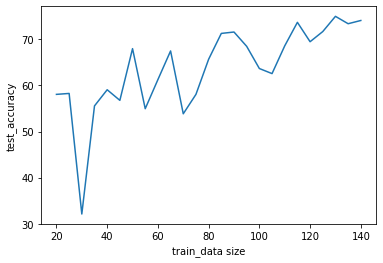

In [604]:
xpoints = np.array(range(140, 15, -5))
ypoints = np.array(test_accs)

plt.plot(xpoints, ypoints)
plt.xlabel("train_data size")
plt.ylabel("test_accuracy")
plt.show()

In [605]:
test_accs

[74.07,
 73.37,
 74.97,
 71.67,
 69.47,
 73.67,
 68.57,
 62.56,
 63.66,
 68.47,
 71.57,
 71.27,
 65.67,
 58.06,
 53.85,
 67.47,
 61.26,
 54.95,
 67.97,
 56.76,
 59.06,
 55.56,
 32.13,
 58.26,
 58.06]

Training data size: 140


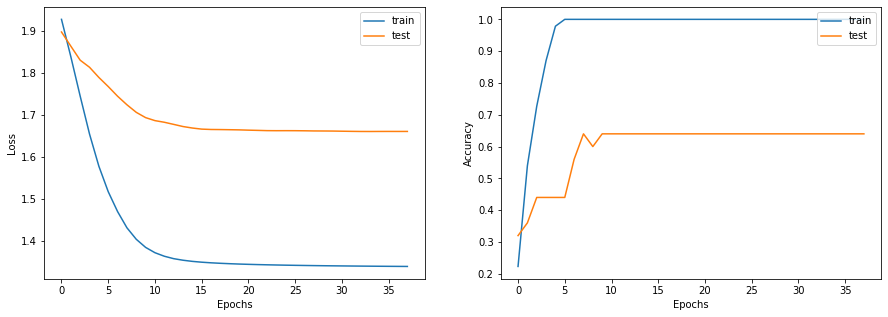

Training data size: 135


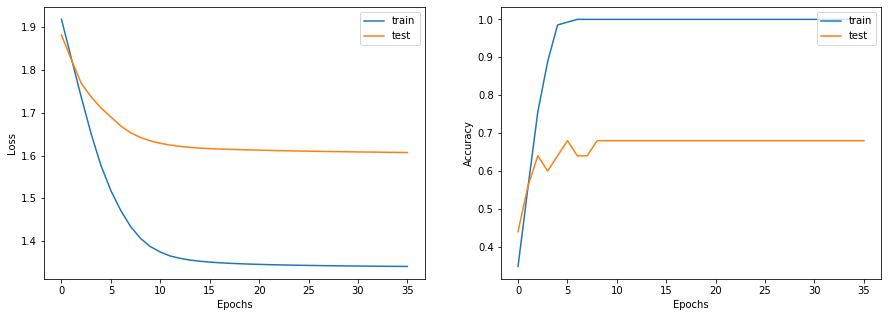

Training data size: 130


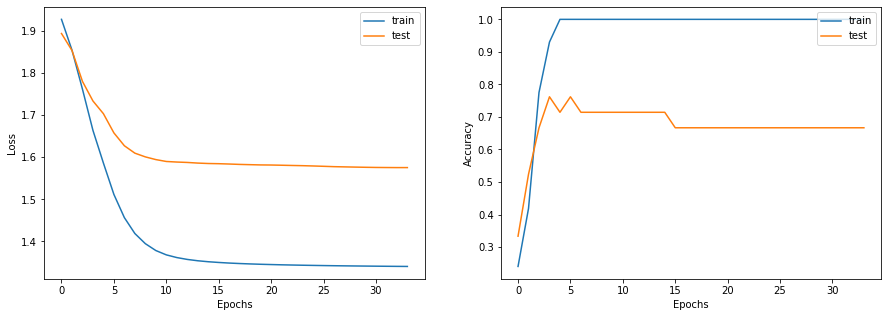

Training data size: 125


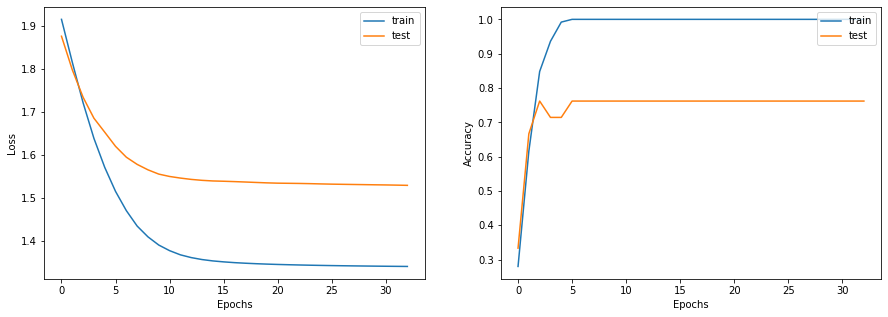

Training data size: 120


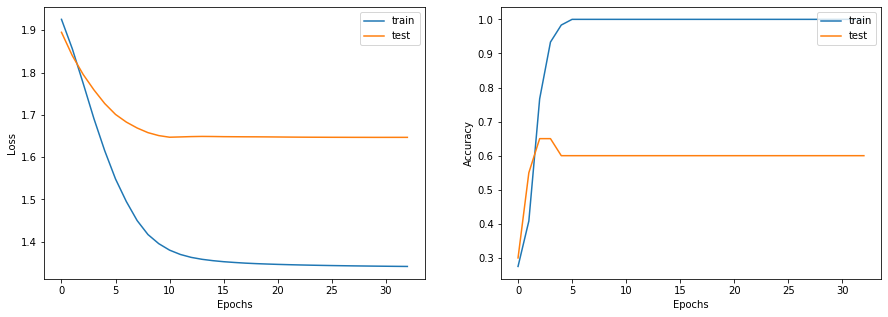

Training data size: 115


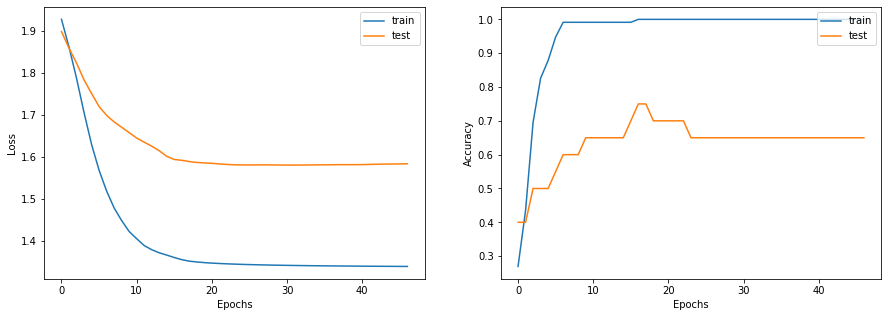

Training data size: 110


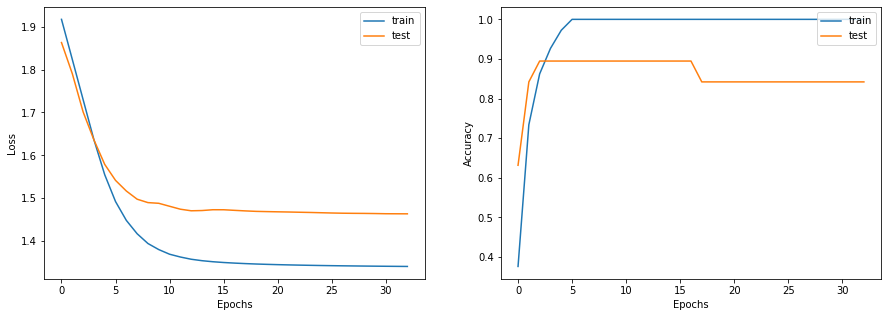

Training data size: 105


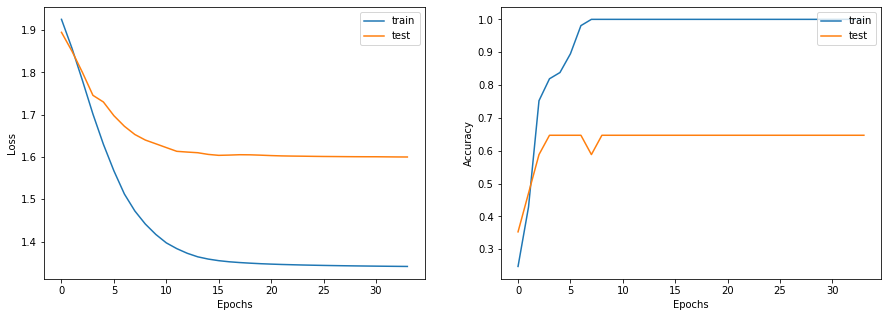

Training data size: 100


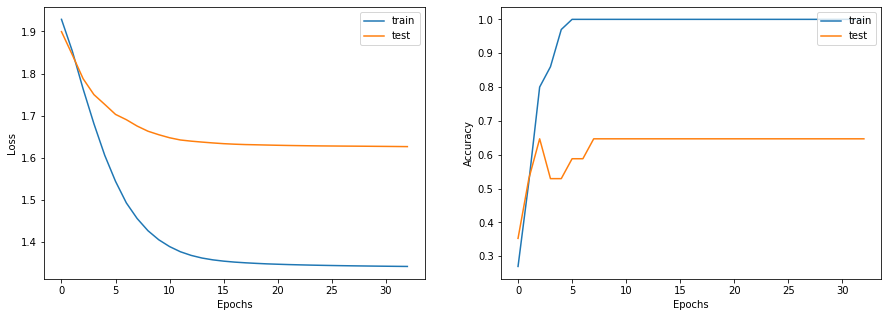

Training data size: 95


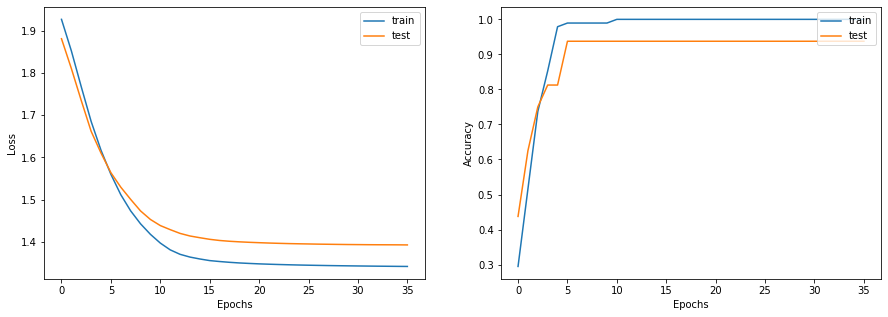

Training data size: 90


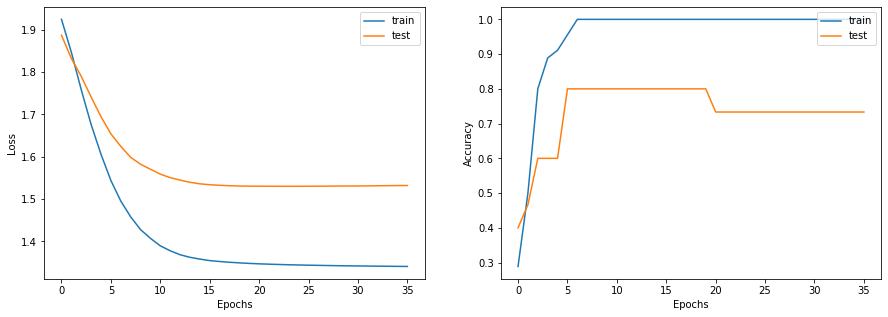

Training data size: 85


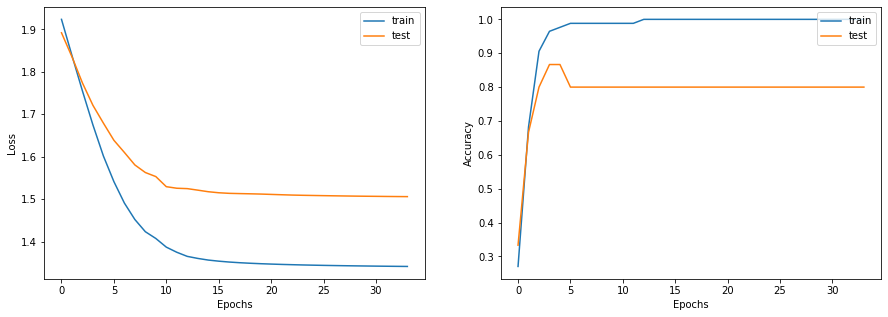

Training data size: 80


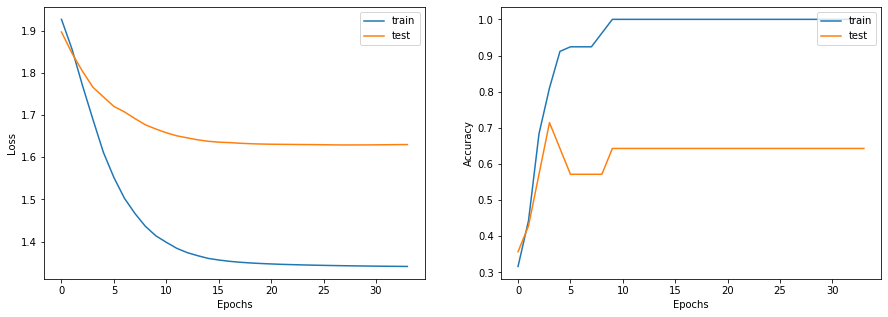

Training data size: 75


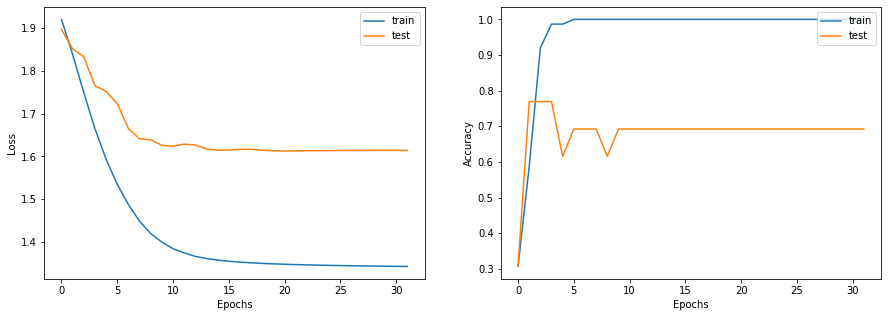

Training data size: 70


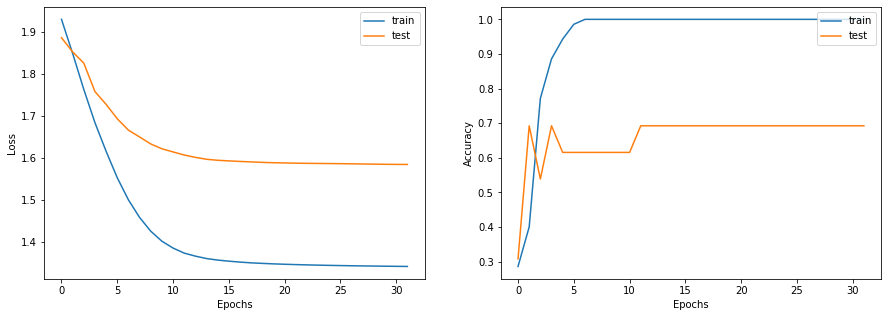

Training data size: 65


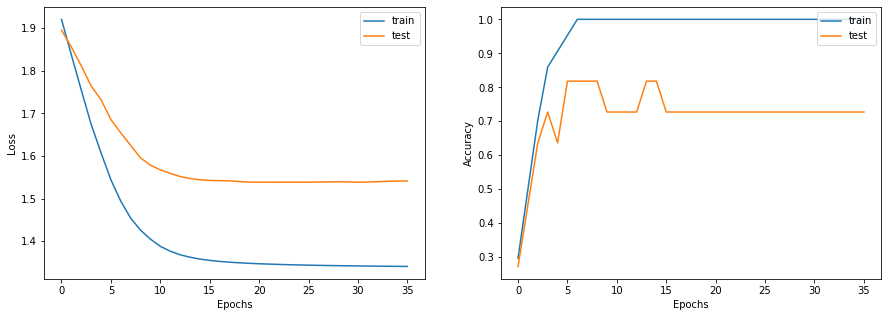

Training data size: 60


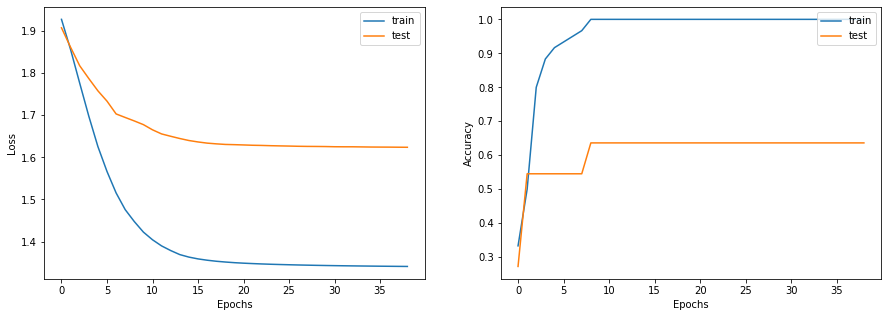

Training data size: 55


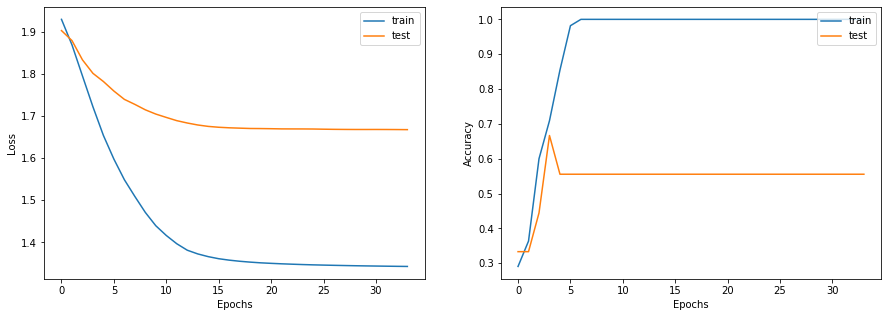

Training data size: 50


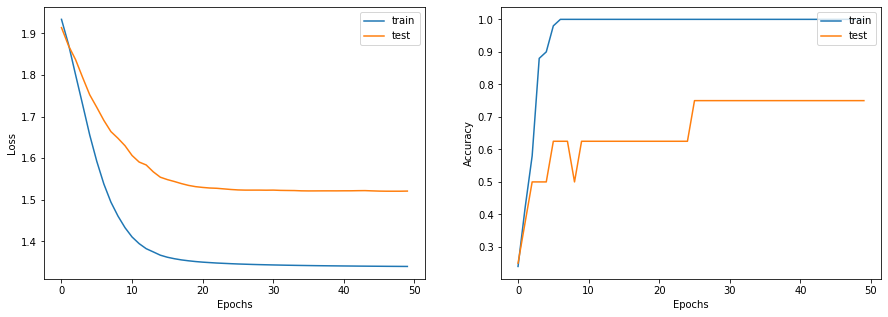

Training data size: 45


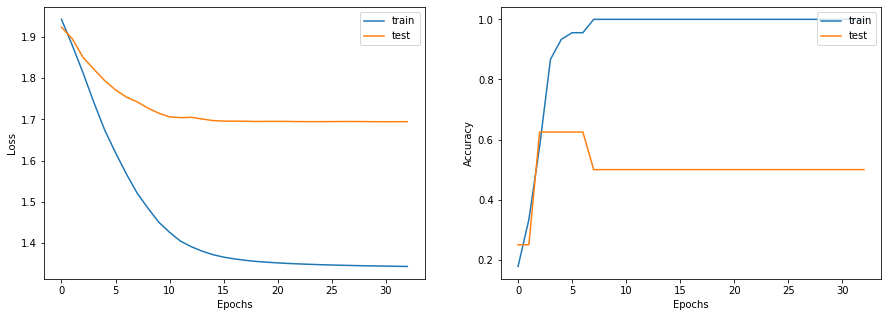

Training data size: 40


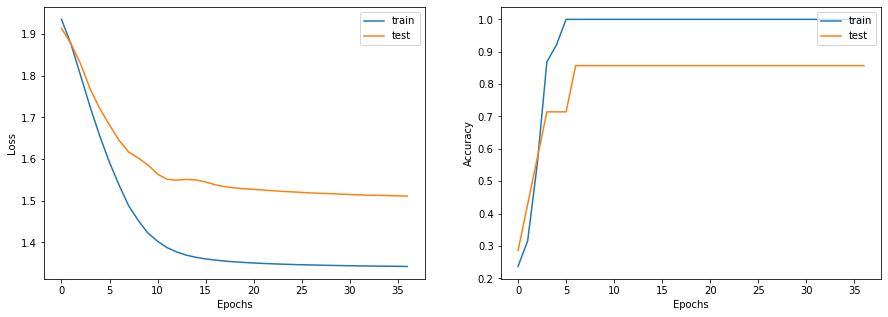

Training data size: 35


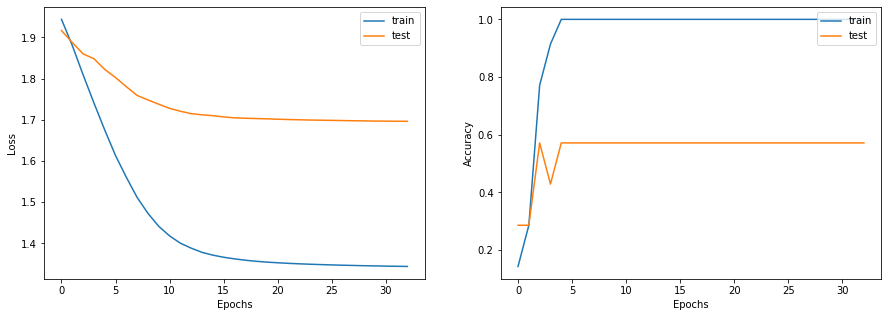

Training data size: 30


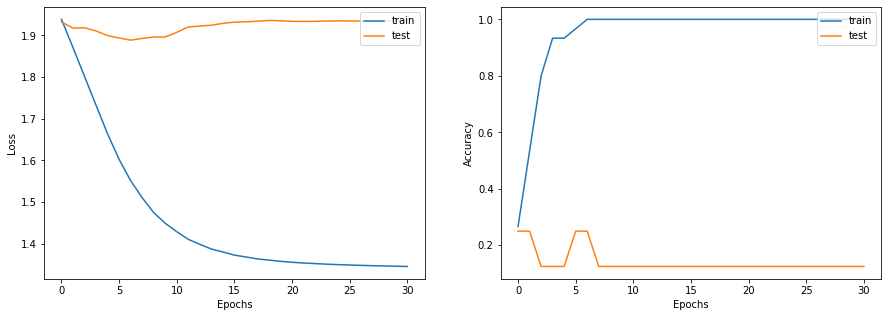

Training data size: 25


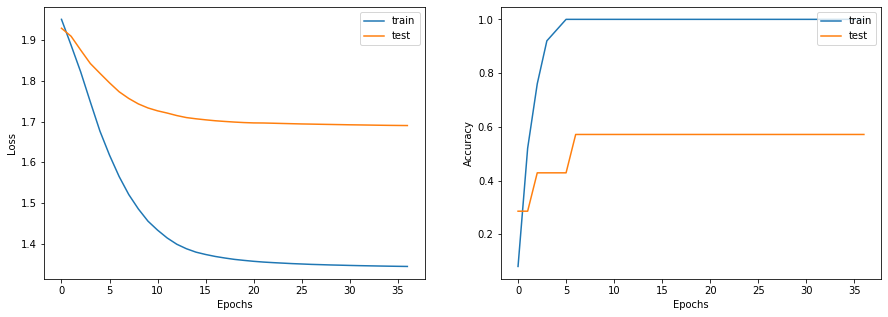

Training data size: 20


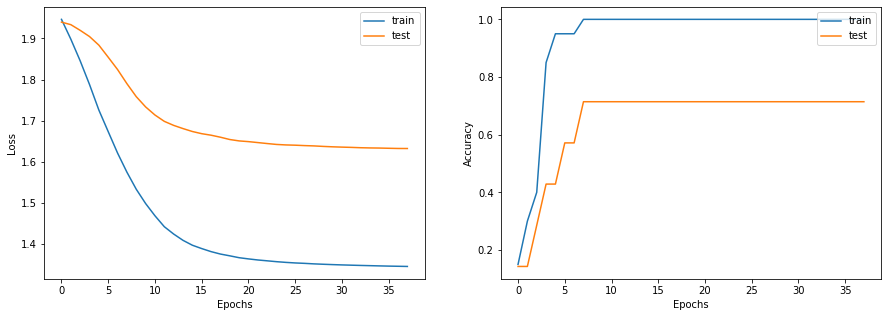

In [606]:
sizes = list(range(140, 5, -5))
for index, hist in enumerate(histories):
    print("Training data size:", sizes[index])
    display_learning_curves(hist)